In [64]:
### import required modules
#!pip3 install xgboost
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from sklearn.feature_selection import chi2,f_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_curve,precision_score,recall_score,auc,precision_recall_curve
from sklearn.model_selection import train_test_split
import xgboost as xgb



In [44]:
## read email data
emails = pd.read_csv('email_table.csv',index_col = 'email_id')

In [45]:
## lokk at sample data
print(emails.info())
emails.head(10)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 85120 to 348333
Data columns (total 6 columns):
email_text             100000 non-null object
email_version          100000 non-null object
hour                   100000 non-null int64
weekday                100000 non-null object
user_country           100000 non-null object
user_past_purchases    100000 non-null int64
dtypes: int64(2), object(4)
memory usage: 5.3+ MB
None


,email_text,email_version,hour,weekday,user_country,user_past_purchases
email_id,,,,,,
85120,short_email,personalized,2,Sunday,US,5
966622,long_email,personalized,12,Sunday,UK,2
777221,long_email,personalized,11,Wednesday,US,2
493711,short_email,generic,6,Monday,UK,1
106887,long_email,generic,14,Monday,US,6
684440,long_email,personalized,6,Sunday,UK,3
139620,short_email,personalized,9,Saturday,US,8
694933,long_email,generic,8,Saturday,US,2
485760,long_email,personalized,5,Monday,US,4


In [46]:
## changing email_text of type short and long to num of paragraphs(numerical value)
### changing email_version to int 
### mapping weekday to numbers using dictionaries
emails['paragraphs'] = np.where(emails.email_text=='short_email',2,4)
#emails['paragraphs'].head()
del emails['email_text']
emails['personal'] = (emails.email_version=='personalized').astype(np.int)
#emails['personal'].head()
del emails['email_version']

dayindex = {'Monday':1, 'Tuesday':2, 'Wednesday':3, 'Thursday':4,'Friday':5,'Saturday':6, 'Sunday':7}
emails['weekday'] = emails.weekday.map(dayindex)


### renaming column names
emails.rename(columns={'user_country':'country', 'user_past_purchases':'purchases'},inplace = True)




In [47]:
## concat email responses data to same dataframe
emails['responses'] = 'received'
open_users = pd.read_csv('email_opened_table.csv').email_id
emails.loc[open_users,'responses']= 'opened'

click_users  = pd.read_csv('link_clicked_table.csv').email_id
emails.loc[click_users,'responses'] = 'clicked'

emails.head()

,hour,weekday,country,purchases,paragraphs,personal,responses
email_id,,,,,,,
85120,2,7,US,5,2,1,received
966622,12,7,UK,2,4,1,clicked
777221,11,3,US,2,4,1,received
493711,6,1,UK,1,2,0,received
106887,14,1,US,6,4,0,received


# Question-1 
a) what percentage of users opened the email?

b ) what percentage clicked the email link

In [55]:
response_count = emails.responses.value_counts(normalize = True)
response_count

received    0.89605
opened      0.08276
clicked     0.02119
Name: responses, dtype: float64

In [59]:
print("{:.2f}% of users opened the email".format((1-response_count.received)*100))
print("{:.2f}% of users clicked the link".format(response_count.clicked*100))

10.39% of users opened the email
2.12% of users clicked the link


In [87]:
### EDA
def count_ratio(df):
    counts = df.responses.value_counts(normalize = True)
    counts['total']= df.shape[0]
    return counts
def grp_count_plot(k):
    grp = emails.groupby(k).apply(count_ratio)
    grp.loc[:,['clicked']].plot(kind = 'bar', title = 'click ratio vs.{}'.format(k))
    plt.ylabel('click ratio')
    return grp

# CHI-Square and f-test to see the significance of input features

In [80]:
responses_encode = LabelEncoder()
country_encoder = LabelEncoder()

X = emails.copy()
y = responses_encode.fit_transform(X.responses)

del X['responses']

features = ['hour','weekday','country','purchases','paragraphs','personal']
X = X.loc[:,features]
X['country'] = country_encoder.fit_transform(X.country)

chi2scores,_ = chi2(X,y)
fscores,_= f_classif(X,y)

feat_scores = pd.DataFrame({'chisquare':chi2scores, 'f_Score':fscores}, index = features)



In [79]:
feat_scores.sort_values(by = 'chisquare', ascending = False)


,chisquare,f_Score
purchases,3448.795660,663.388596
country,378.554465,435.696911
personal,316.752872,317.427444
weekday,210.006087,105.002643
hour,147.815921,33.992047
paragraphs,53.952439,81.209295


In [81]:
feat_scores.sort_values(by = 'f_Score', ascending = False)


,chisquare,f_Score
purchases,3448.795660,663.388596
country,378.554465,435.696911
personal,316.752872,317.427444
weekday,210.006087,105.002643
paragraphs,53.952439,81.209295
hour,147.815921,33.992047


# from above test results, importan features are users purchases,
### coutry and email_version and others are less important

In [85]:
## Purchases vs responses
grpby_purchase = emails.groupby('purchases').apply(count_ratio).unstack()
grpby_purchase.fillna(value = 0, inplace=True)


Text(0, 0.5, 'ratio')

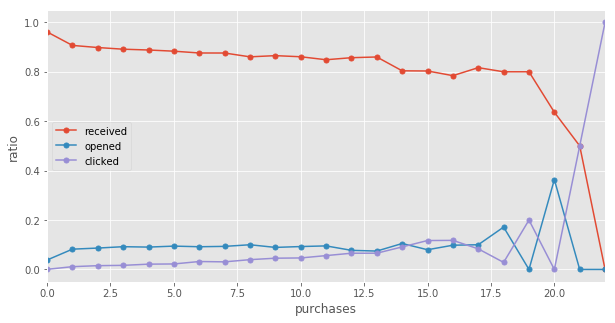

In [86]:
plt.rc('figure', figsize = (10,5))
grpby_purchase.loc[:,['received','opened','clicked']].plot(marker = 'o', markersize = 5)
plt.ylabel('ratio')

# from above plot we can see that as the num of purchsaes increases the more the user is likely to click or open the email.

responses,received,opened,clicked,total
country,,,,
ES,0.960570,0.031103,0.008327,9967.0
FR,0.958779,0.033217,0.008004,9995.0
UK,0.879282,0.096043,0.024675,19939.0
US,0.880481,0.095160,0.024360,60099.0


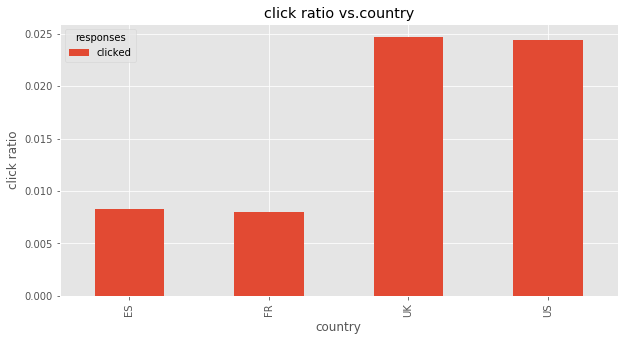

In [88]:
### country vs responses
grp_count_plot('country')

# US AND UK HAVE HIGH(3 TIMES) CLICK RATE AND OPEN % , WHICH SHOWS THAT EFECT OF EMAIL LANGUAGE IN FRANCE AND SPAIN WHIH IS NOT ENGLISH MOSTLY

responses,received,opened,clicked,total
personal,,,,
0,0.920034,0.064829,0.015137,50209.0
1,0.871864,0.100842,0.027294,49791.0


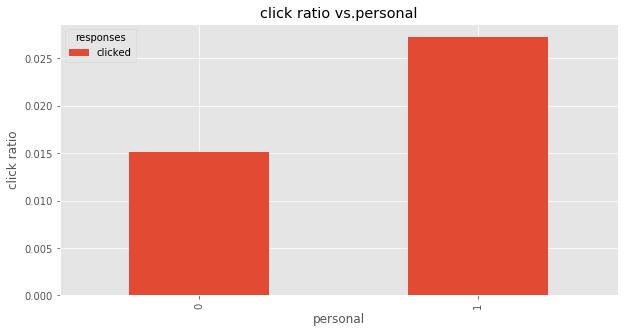

In [89]:
### email_version vs responses
grp_count_plot('personal')

# personal mails have hisgherr click rate than generic ,whcih shows that if a mail has some name/ref to the reciever its more likely they open/click it

responses,received,opened,clicked,total
weekday,,,,
1,0.883590,0.093504,0.022906,14363.0
2,0.879092,0.096019,0.024889,14143.0
3,0.879296,0.093084,0.027620,14084.0
4,0.881348,0.094207,0.024445,14277.0
5,0.925019,0.060944,0.014037,14177.0
6,0.912005,0.070149,0.017846,14569.0
7,0.911448,0.071801,0.016751,14387.0


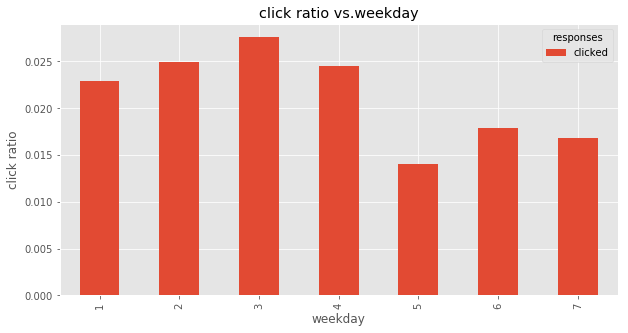

In [90]:
# Weekday vs responses
grp_count_plot('weekday')

# its evident from fig that people generally don't reply to mails on weekends

responses,received,opened,clicked,total
paragraphs,,,,
2,0.883698,0.092430,0.023872,49724.0
4,0.908266,0.073196,0.018538,50276.0


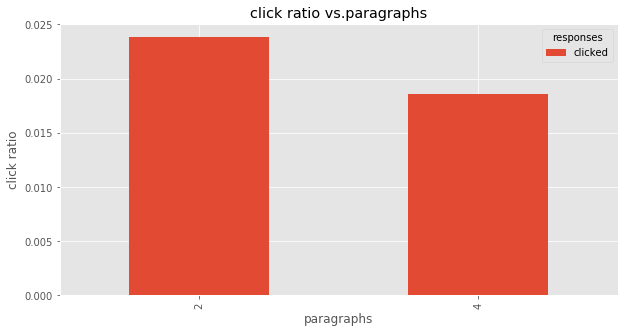

In [91]:
## text vs responses
grp_count_plot('paragraphs')

# small text emails have comparable advantage than longer emails in clicking/opening the mail

responses,received,opened,clicked,total
hour,,,,
1,0.910840,0.071032,0.018128,2703.0
2,0.911589,0.072089,0.016322,3676.0
3,0.915184,0.065293,0.019523,4610.0
4,0.911419,0.072394,0.016186,5622.0
5,0.917417,0.064570,0.018013,6551.0
6,0.909176,0.073677,0.017147,7465.0
7,0.909434,0.072282,0.018284,8204.0
8,0.911407,0.069659,0.018933,8398.0
9,0.873725,0.100481,0.025794,8529.0


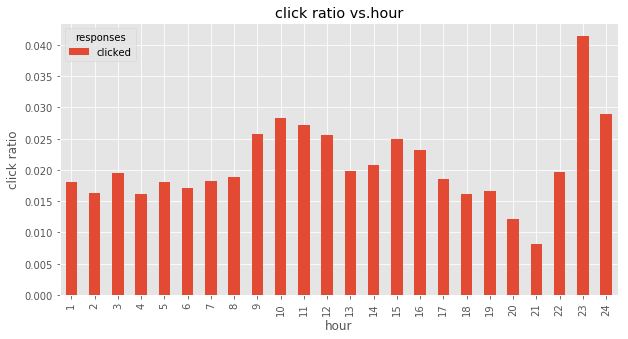

In [92]:
### sending hr vs responses
grp_count_plot('hour')

# from fig its slightly misleaading that late hrs(23,24) will have more cloick ration , which might not be the case in real world scenario

# Q-2)Any interesting patterns in user segments?
Ans:from above visulaizations we can have some insights like:
a) more num of purchases leads to higher click/open ratio
b) English speaking countries have higher chance of clicking a email
c) Personalized emails have more probability to be clicked
d) Emails on weekends have lower possibilty to be opened/clicked
    
    
        


In [93]:
##3 predictive modelling to check whether a user opens/clicks the link

### prepare the data
del X
X = emails.copy()
X.sample(5)

,hour,weekday,country,purchases,paragraphs,personal,responses
email_id,,,,,,,
310873,17,1,US,1,2,1,opened
682380,4,1,UK,0,4,0,received
55483,7,1,US,4,4,1,received
641721,11,5,UK,1,2,1,received
515175,16,1,US,3,2,1,received


In [94]:
### select features 
X = X.loc[:,['country','purchases','paragraphs','personal']]

## new features
X['weekend'] = (emails.weekday>=5).astype(int)

## labelling for countries 
X = pd.get_dummies(X,columns = ['country'],drop_first = True)

### target/output variable

y = (emails.responses=='clicked').astype(int)


In [95]:
X.sample(10)

,purchases,paragraphs,personal,weekend,country_FR,country_UK,country_US
email_id,,,,,,,
770958,3,4,0,0,0,0,1
904600,2,4,1,1,0,1,0
42769,5,4,1,1,0,0,1
646584,3,2,0,0,0,1,0
181575,2,2,1,1,0,1,0
867543,6,4,0,1,0,0,1
561588,4,4,1,0,0,1,0
528122,0,2,1,0,0,0,1
767514,2,4,1,0,0,0,1


In [96]:
### split data into train, test
seed = 9999
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size = 0.3, random_state = seed)

In [121]:
print('X_train size:',(Xtrain.shape),'pos ratio:', ytrain.mean(), 'X_test size:',(Xtest.shape), 'pos ratio:', ytest.mean())

X_train size: (70000, 7) pos ratio: 0.020871428571428572 X_test size: (30000, 7) pos ratio: 0.021933333333333332


In [103]:
train_mat = xgb.DMatrix(Xtrain,ytrain)
test_mat = xgb.DMatrix(Xtest,ytest)


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [105]:
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'auc'
params['num of rounds'] = 300
params['early stopping'] = 30
params['max_depth'] = 6
params['eta'] = 0.1
params['subsample'] = 0.8
params['colsample_bytree'] = 0.8
cv_res = xgb.cv(params,train_mat,
                num_boost_round = params['num of rounds'],nfold = params.get('nfold',5),
                metrics = params['eval_metric'],early_stopping_rounds = params['early stopping'],
                verbose_eval = True,
                seed = seed)

[0]	train-auc:0.576041+0.00272557	test-auc:0.575998+0.0110864
[1]	train-auc:0.624188+0.0595457	test-auc:0.617825+0.0546517
[2]	train-auc:0.675353+0.0445142	test-auc:0.667392+0.0486274
[3]	train-auc:0.700686+0.0105298	test-auc:0.691674+0.0245388
[4]	train-auc:0.707009+0.00476171	test-auc:0.699824+0.0228616
[5]	train-auc:0.709677+0.0088573	test-auc:0.706293+0.0194959
[6]	train-auc:0.717521+0.00633792	test-auc:0.71051+0.017332
[7]	train-auc:0.722956+0.00602538	test-auc:0.716068+0.0119918
[8]	train-auc:0.72828+0.00526188	test-auc:0.719139+0.0142862
[9]	train-auc:0.730741+0.00282781	test-auc:0.722359+0.0159838
[10]	train-auc:0.732786+0.00310568	test-auc:0.722225+0.0149809
[11]	train-auc:0.732575+0.0028977	test-auc:0.722007+0.0145035
[12]	train-auc:0.735967+0.00396502	test-auc:0.724443+0.0152785
[13]	train-auc:0.737411+0.00301909	test-auc:0.725439+0.0137287
[14]	train-auc:0.739475+0.00301422	test-auc:0.727905+0.0133855
[15]	train-auc:0.740948+0.00344662	test-auc:0.729683+0.0131901
[16]	train

In [108]:
n_trees = cv_res.shape[0]
print('best num of trees :',n_trees)

best num of trees : 62


In [109]:
watch = [(train_mat,'train')]
gbt = xgb.train(params,train_mat,n_trees,watch)


[0]	train-auc:0.576045
[1]	train-auc:0.713687
[2]	train-auc:0.721111
[3]	train-auc:0.720434
[4]	train-auc:0.7205
[5]	train-auc:0.726543
[6]	train-auc:0.730708
[7]	train-auc:0.731175
[8]	train-auc:0.731734
[9]	train-auc:0.733679
[10]	train-auc:0.739023
[11]	train-auc:0.739325
[12]	train-auc:0.738813
[13]	train-auc:0.739319
[14]	train-auc:0.739641
[15]	train-auc:0.7405
[16]	train-auc:0.742671
[17]	train-auc:0.743437
[18]	train-auc:0.743631
[19]	train-auc:0.744647
[20]	train-auc:0.74587
[21]	train-auc:0.746086
[22]	train-auc:0.746827
[23]	train-auc:0.747613
[24]	train-auc:0.748258
[25]	train-auc:0.748475
[26]	train-auc:0.748359
[27]	train-auc:0.749128
[28]	train-auc:0.749154
[29]	train-auc:0.750423
[30]	train-auc:0.750357
[31]	train-auc:0.751763
[32]	train-auc:0.751931
[33]	train-auc:0.75254
[34]	train-auc:0.75231
[35]	train-auc:0.753269
[36]	train-auc:0.75379
[37]	train-auc:0.754804
[38]	train-auc:0.755175
[39]	train-auc:0.755767
[40]	train-auc:0.75565
[41]	train-auc:0.756075
[42]	train-

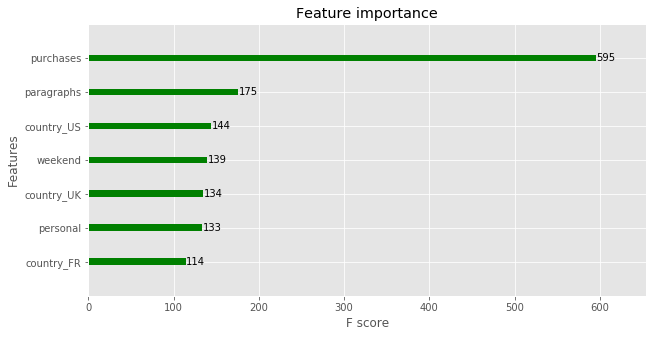

In [119]:
### feature importance in building model
xgb.plot_importance(gbt, color = 'green')

# pos ratio is only 2% which is not good if we set 0.5 as prob threshold from which the model can classify everything as neg,
so we choose a best prob threshold to classify better based on roc curve 





In [122]:
print(params)

{'objective': 'binary:logistic', 'eval_metric': 'auc', 'num of rounds': 300, 'early stopping': 30, 'max_depth': 6, 'eta': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8}


In [125]:
def validation_roc():
    X_train, X_valid, y_train, y_valid  = train_test_split(Xtrain,ytrain, test_size = 0.2,random_state =seed)
    train_matrix = xgb.DMatrix(X_train,y_train)
    valid_mat = xgb.DMatrix(X_valid)
    ##retrain
    gbt_train = xgb.train(params,train_matrix,n_trees)
    y_prob_predict = gbt_train.predict(valid_mat,ntree_limit = n_trees)
    d = {}
    d['FPR'], d['TPR'],d['Threshold'] =roc_curve(y_valid,y_prob_predict)
    return pd.DataFrame(d)


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Text(0, 0.5, 'TPR')

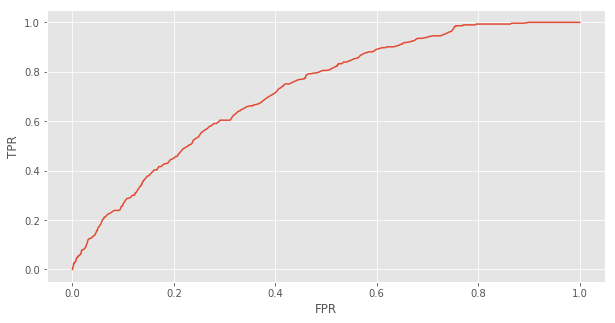

In [127]:
roc_res = validation_roc()
_ = plt.figure()
plt.plot(roc_res.FPR, roc_res.TPR)
plt.xlabel("FPR")
plt.ylabel("TPR")


# from fig we can choose tpr as 0.6, fpr as 0.3

In [128]:
roc_res.loc[(roc_res.TPR>0.6)& (roc_res.TPR<0.65),:]



,FPR,TPR,Threshold
189,0.290071,0.600683,0.026722
190,0.290217,0.600683,0.026694
191,0.290727,0.604096,0.026548
192,0.294156,0.604096,0.026464
193,0.295032,0.604096,0.026388
194,0.308601,0.604096,0.026338
195,0.308893,0.604096,0.026255
196,0.311082,0.604096,0.026154
197,0.312176,0.607509,0.026106
198,0.316262,0.621160,0.025640


In [129]:
### fpr = 0.328299, tpr = 0.641638, threshold = 0.025587
pos_prob = 0.025587

def predict_var(mat):
    y_prob=gbt.predict(mat,ntree_limit = n_trees)
    return (y_prob>pos_prob).astype(int)


In [130]:
ytrain_pred = predict_var(train_mat)
print(classification_report(ytrain,ytrain_pred))

              precision    recall  f1-score   support

           0       0.99      0.69      0.82     68539
           1       0.04      0.67      0.08      1461

   micro avg       0.69      0.69      0.69     70000
   macro avg       0.52      0.68      0.45     70000
weighted avg       0.97      0.69      0.80     70000



In [131]:
ytest_pred = predict_var(test_mat)
print(classification_report(ytest,ytest_pred))

              precision    recall  f1-score   support

           0       0.99      0.69      0.81     29342
           1       0.04      0.63      0.08       658

   micro avg       0.69      0.69      0.69     30000
   macro avg       0.52      0.66      0.45     30000
weighted avg       0.97      0.69      0.80     30000



In [134]:
print('precison score:',precision_score(ytest, ytest_pred)*100)
print('recall % :',recall_score(ytest,ytest_pred)*100)

precison score: 4.378412431751364
recall % : 63.37386018237082


# Q 3) VP of marketing wants to know how to improve the click% using the model and how to test that
Ans: send mails only based on GBM model prediction and compare the results

In [136]:
n_old_emails = ytest_pred.shape[0]
n_emails_new = ytest_pred.sum()
savings = 100- n_emails_new * 100/n_old_emails
pd.Series({'emails old way': n_old_emails,
          'emails new way' : n_emails_new,
          'savings %': savings})

emails old way    30000.000000
emails new way     9524.000000
savings %            68.253333
dtype: float64

# Finally model test : Statistical test (A/B test)
    1. divide into 2 grps , existing and new
    2. In existing grp send the emails old way
    3. In new grp send to  pos predicted emails
    4. compare 2 grps using t-test one-sided using the population proportion results